In [1]:
import numpy as np
import torch 
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, 'src/')

from src.model.vae import VAE_Encoder, VAE_Decoder
from src.model.config import StableDiffusionConfig
from src.model.unet import UNet
from src.model.clip import CLIPEncoder
from src.model.diffusion import StableDiffusion
from src.utils import forward_diffusion
from src.model.dataset import get_dataloader

from PIL import Image

from torchinfo import summary

from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from torchvision.transforms import Compose, Lambda, Resize, ToPILImage, ToTensor

config = StableDiffusionConfig()

In [2]:
dl = get_dataloader(config)

In [3]:
next(enumerate(dl))

(0,
 [('A black bear standing in a field of grass.',
   [''],
   "A clock showing four o'clock with bells to toll the hour mounted on the outside of a building",
   'A man in a hip pose in front of a large clock tower.',
   'Groups of people are gathered around different tables.',
   'a big brown bear drinks water from a lake',
   'street signs with arrows that point up and to the right ',
   'A plane leaves a long contrail in the air.',
   [''],
   'Boys at a skate park watching another boy do a trick on his skate board. ',
   [''],
   'Adults posing in bathroom while man is brushing teeth.',
   'A hand holding a donut with sprinkles during the day.',
   'Two people are playing a WII video game.',
   [''],
   [''],
   [''],
   [''],
   'A giraffe standing next to a tall grass feeder.',
   [''],
   'a thin man shaking hands with a thin lady in a red and turquoise suit',
   'A plate with a donut on it and a creamer',
   'A girl on a cellphone at a down town cross walk.',
   'There is a 

Stable Diffusion

In [25]:
img = Image.open('data/img.jpg')

In [26]:
trans = Compose([Resize((256, 256)), ToTensor(), Lambda(lambda t: (t * 2) - 1)])

In [28]:
img_tensor = trans(img)

In [41]:
img_t1 = forward_diffusion(config, img_tensor.to(config.device), torch.tensor([600], device=config.device))

In [42]:
def show_tensor_image(image):
    
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),
        Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        Lambda(lambda t: t * 255.),
        Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

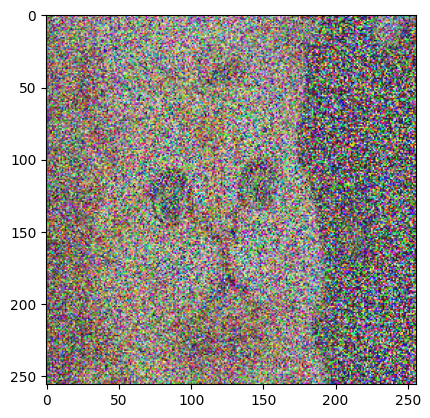

In [43]:
show_tensor_image(img_t1[0])

In [2]:
img = torch.randn((1, config.img_channels, config.img_size, config.img_size))
tokens = torch.randint(low=0, high=config.vocab_size, size=(1, config.clip_seq_len))
time = torch.randn((1, config.unet_time_emb_dim))

In [3]:
model = StableDiffusion(config)

In [4]:
img_size = (1, config.img_channels, config.img_size, config.img_size)

In [5]:
model(img, tokens, time)

torch.Size([1, 1280, 4, 4])
torch.Size([1, 1280, 4, 4])


RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [2560] and input of shape [1, 1280, 4, 4]

In [ ]:
summary(model, [img_size, (1, config.clip_seq_len)])

Layer (type:depth-idx)                                  Output Shape              Param #
StableDiffusion                                         [32, 4, 32, 32]           882,807,447
├─VAE_Encoder: 1-1                                      [32, 4, 32, 32]           --
│    └─Conv2d: 2-1                                      [1, 128, 256, 256]        3,456
│    └─ModuleList: 2-2                                  --                        --
│    │    └─VAE_Block: 3-1                              [1, 128, 128, 128]        442,880
│    │    └─VAE_Block: 3-2                              [1, 256, 64, 64]          1,508,352
│    │    └─VAE_Block: 3-3                              [1, 512, 32, 32]          6,031,360
│    └─Sequential: 2-3                                  [1, 512, 32, 32]          --
│    │    └─VAE_Block: 3-4                              [1, 512, 32, 32]          4,720,640
│    │    └─VAE_Block: 3-5                              [1, 512, 32, 32]          4,720,640
│    │    └─VAE

VAE

In [8]:
enc = VAE_Encoder(config.img_channels, config.vae_features_dims, config.vae_num_groups, config.vae_num_heads, config.vae_dropout, config.vae_latent_dim)

print(sum(p.numel() for p in enc.parameters()))

23237584


UNET

In [4]:
model = UNet(config.vae_latent_dim, config.unet_features_dims, config.unet_attn_num_heads, config.unet_attn_dim, config.unet_time_emb_dim, config.unet_time_emb_dim_scale_factor)

In [5]:
sum(p.numel() for p in model.parameters())

852620804

In [17]:
[img.shape, noise.shape]

[torch.Size([1, 3, 512, 512]), torch.Size([1, 4, 64, 64])]

In [9]:
summary(enc, [(1, 3, 512, 512), (1, 4, 64, 64)])

Layer (type:depth-idx)                             Output Shape              Param #
VAE_Encoder                                        [1, 4, 64, 64]            --
├─Conv2d: 1-1                                      [1, 128, 512, 512]        3,456
├─ModuleList: 1-2                                  --                        --
│    └─VAE_Block: 2-1                              [1, 128, 256, 256]        --
│    │    └─PrenormResidualConnection: 3-1         [1, 128, 512, 512]        147,712
│    │    └─PrenormResidualConnection: 3-2         [1, 128, 512, 512]        147,712
│    │    └─Conv2d: 3-3                            [1, 128, 256, 256]        147,456
│    └─VAE_Block: 2-2                              [1, 256, 128, 128]        --
│    │    └─PrenormResidualConnection: 3-4         [1, 256, 256, 256]        328,192
│    │    └─PrenormResidualConnection: 3-5         [1, 256, 256, 256]        590,336
│    │    └─Conv2d: 3-6                            [1, 256, 128, 128]        589,824
│ 

In [ ]:
summary()

In [6]:
time = torch.randn((1, config.unet_time_emb_dim))
model(out, time)

TypeError: SwitchSequential.forward() missing 1 required positional argument: 'time'

In [2]:

tokens.shape

torch.Size([1, 77])

In [3]:
clip = CLIPEncoder(config.vocab_size, config.clip_emb_dim, config.clip_seq_len,
                   config.clip_attn_num_heads, config.clip_emb_dim_scale_factor, 
                   config.clip_num_layers, config.clip_dropout).to('cuda')

In [4]:
sum(p.numel() for p in clip.parameters())

123060480

In [1]:
import torch

torch.save({
    'epoch' : 1
}, "src/model/weights/stable_diffusion_7.pth")

In [ ]:
UNet_AttentionBlock

In [6]:
text_emb = clip(tokens)

In [7]:
text_emb.shape

torch.Size([1, 77, 768])

In [4]:
from torch import nn

In [5]:
out.shape

torch.Size([1, 4, 64, 64])

In [6]:
dec = VAE_Decoder(config.vae_latent_dim, config.vae_features_dims, config.vae_num_groups, config.vae_dropout, config.vae_num_heads, config.img_channels)

In [7]:
print(sum(p.numel() for p in dec.parameters()))

32367379


In [8]:
dec = dec.to('cuda')

In [9]:
dec(out).shape

torch.Size([1, 4, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 128, 128])
torch.Size([1, 256, 256, 256])
torch.Size([1, 128, 512, 512])


torch.Size([1, 3, 512, 512])